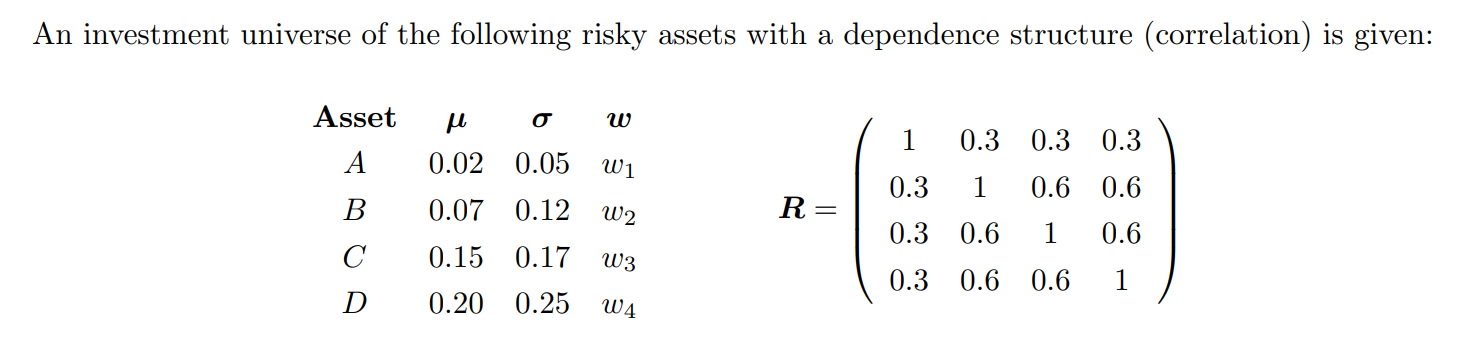

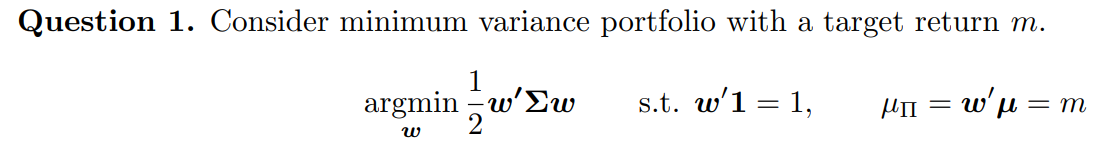

In [121]:
import numpy as np
np.random.seed(0)

In [122]:
def optimize_portfolio(mus,stds,R,m='global_min'):
    '''
    Parameters
    ----------
    mus : np.array
        return vector.
    stds : np.array
        standard deviation vector.
    R : np.array
        DESCRIPTION.
    m : 'global_min' or float
        global minimum variance portfolio if return is not specified.
    Returns
    -------
    w_star : np.array
        optimal allocations.
    '''
    dim=R.shape[0]
    unit=np.ones(dim)
    S=np.diag(stds)
    sigma=S.T.dot(R).dot(S)

    A=unit.T.dot(np.linalg.inv(sigma)).dot(unit)
    B=mus.T.dot(np.linalg.inv(sigma)).dot(unit)
    C=mus.T.dot(np.linalg.inv(sigma)).dot(mus)
    if m=='global_min':
        m=B/A
    w_star=1/(A*C-B**2)*np.linalg.inv(sigma).dot((A*mus-B*unit)*m+(C*unit-B*mus))
        
    return w_star,sigma

In [123]:
w_star,sigma=optimize_portfolio(mus, stds, R, m='global_min')
print(w_star)

[ 0.9426708   0.11195005 -0.00606273 -0.04855812]


Formulate the Lagrangian and give its partial derivatives.
$$
\begin{aligned}
& \Large L(w,\lambda, \gamma)=\frac{1}{2}w^T \Sigma w + \lambda (m- w^Tu) + \gamma (1_{N}-w^T 1_{N}) \\
& \Large \frac{\partial L}{\partial w}(w,\lambda, \gamma)=\Sigma w - \lambda u - \gamma 1_{N}
\end{aligned}
$$

Write down the analytical solution for optimal allocations w∗
(derivation not required).
$$
\begin{aligned}
& \Large A=1_{N}^T \Sigma ^{-1} 1_{N} \\
& \Large B=u^T \Sigma ^{-1} 1_{N} = 1_{N}^T \Sigma ^{-1} u \\
& \Large C=u^T \Sigma ^{-1} u \\
& \Large m=\frac{B}{A} \\
\end{aligned}
$$

$$
\begin{aligned}
\Large w^* &=\frac{1}{AC-B^2} \Sigma ^{-1} [(Au-B 1_{N})m+(C 1_{N}-Bu)] \\
&=\frac{\Sigma ^{-1}1_{N}}{A} \\
&=[ 0.9426708 ,  0.11195005, -0.00606273, -0.04855812]
\end{aligned}
$$

Inverse optimisation: generate above 700 random allocation sets (vectors) 4 × 1, those will not be
optimal allocations.

In [124]:
ws=[np.random.random(R.shape[0]) for _ in range(700)]  ##700 random allocation sets

Standardise each set to satisfy $w^T 1_{N}$ = 1, in fact you can generate 3 allocations and compute the 4th.

In [125]:
ws_norm=list(map(lambda w:w/sum(w),ws))       ##700 random allocation sets which  satisfy w1 = 1
print(ws_norm[3])

[0.34389291 0.56035414 0.04300507 0.05274788]


For each vector of allocations compute $u_{\pi}=w^T u$ and $\sigma_{\pi}=\sqrt{w^T \Sigma w}$

In [126]:
mus_port=list(map(lambda w:w.T.dot(mus),ws_norm)) 
stds_port=list(map(lambda w:np.sqrt(w.T.dot(sigma).dot(w)),ws_norm)) 

Plot the cloud of points of $u_{\pi}$ vertically on $\sigma_{\pi}$ horizontally. Explain this plot.

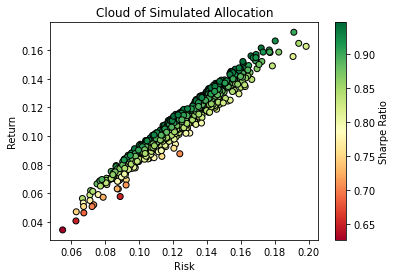

In [127]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
ax.set_title('Cloud of Simulated Allocation')
ax.set_xlabel('Risk')
ax.set_ylabel('Return')
fig.colorbar(ax.scatter(stds_port, mus_port, c=np.array(mus_port) / np.array(stds_port), 
                        marker='o', cmap='RdYlGn', edgecolors='black'), label='Sharpe Ratio') 

Explain this plot:  
1.The diagram above includes 700 points of portfolio-return vertically on portfolio-risk horizontally.  
2.Each weight vector is uniform sampling between [0,1] and sum of vector equals to 1.  
3.The color of point represent the sharp-ratio.  
4.As we vary weight vector, so the Risk and the Return change. The cloud points of risk/return space
parameterized by weight vector is nearly a straight line because correlation among risky assets are relatively large. The top edge of this cloud with deep green color are more efficient and preferable than rest of allocations

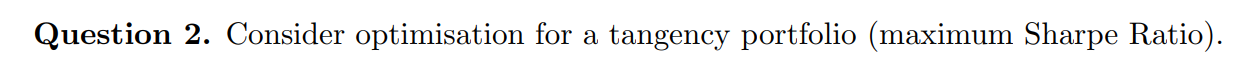

Formulate optimisation expression.
$$
\Large min_{w} \quad \frac{1}{2}w^T \Sigma w \quad st.\quad r+w^{T}(u-r 1_{N})=m
$$

Formulate Lagrangian function and give its partial derivatives only.
$$
\begin{aligned}
& \Large L(w,\lambda)=\frac{1}{2}w^T \Sigma w + \lambda (m-r-w^T(u-r1_{N})) \\
& \Large \frac{\partial L}{\partial w}(w,\lambda)=\Sigma w - \lambda (u - \gamma 1_{N})
\end{aligned}
$$

For the range of tangency portfolios given by rf = 50bps, 100bps, 150bps, 175bps optimal compute
allocations (ready formula) and σΠ. Present results in a table

In [128]:
def tangency_portfolio(mus,stds,R,r):
    '''
    Parameters
    ----------
    mus : np.array
        return vector.
    stds : np.array
        standard deviation vector.
    R : np.array
        DESCRIPTION.
    r : float
        risk-free asset rate
    Returns
    -------
    w_tangency : np.array
        tangency allocation weight.
    mu_tangency : float
        tangency allocation return.
    std_tangency : float
        tangency allocation risk.
    '''
    dim=R.shape[0]
    unit=np.ones(dim)
    S=np.diag(stds)
    sigma=S.T.dot(R).dot(S)

    A=unit.T.dot(np.linalg.inv(sigma)).dot(unit)
    B=mus.T.dot(np.linalg.inv(sigma)).dot(unit)
    C=mus.T.dot(np.linalg.inv(sigma)).dot(mus)
    
    w_tangency=np.linalg.inv(sigma).dot(mus-r*unit)
    mu_tangency=(C-B*r)/(B-A*r)
    std_tangency=np.sqrt((C-2*r*B+r**2*A)/((B-A*r)**2))
        
    return w_tangency, mu_tangency, std_tangency

In [129]:
import pandas as pd
df=pd.DataFrame()
df.index=['r50','r100','r150','r175']
ws_tan=[]
mus_tan=[]
stds_tan=[]
for r in [0.005,0.01,0.015,0.0175]:
    w_tangency, mu_tangency, std_tangency=tangency_portfolio(mus, stds, R, r=r)
    ws_tan.append(str(w_tangency))
    mus_tan.append(str(mu_tangency))
    stds_tan.append(str(std_tangency))
df['weight_tan']=ws_tan
df['return_tan']=mus_tan
df['stds_tan']=stds_tan

In [131]:
df

,weight_tan,return_tan,stds_tan
r50,[ 0.07893935 -1.07548935 3.81839737 1.86709845],0.1860703582017637,0.19651064153082887
r100,[-1.91770802 -1.31260794 3.83123868 1.96994819],0.32613023098824145,0.3506653701427944
r150,[-3.91435538 -1.54972654 3.84408 2.07279793],1.7765254343453165,1.9723916979145162
r175,[-4.91267906 -1.66828584 3.85050065 2.1242228 ],-1.2987994672869811,1.4735149302364068
